In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad

'''
 We will borrow the filterpy package as our EKF utility. Reference to be added later
'''
from functools import partial
style.use('fivethirtyeight')


In [3]:
def single_meas_func(C1,C0,k,b,dist):
    return k*jnp.power(dist-C1,b)+C0


def joint_meas_func(C1s,C0s,ks,bs,q,ps):

    # Casting for the compatibility of jax.numpy
#     q = q.reshape(2,1)
#     ps = ps.reshape(2,-1)
    dists=jnp.linalg.norm(q-ps,axis=1)

    return single_meas_func(C1s,C0s,ks,bs,dists) 
def FIM(C1s,C0s,ks,bs,sigma=1):
    """
       The computation of Fish Information Matrix, using definition.
    """
    
    H=partial(joint_meas_func, C1s,C0s,ks,bs)
    
    # Taking partial derivative of H w.r.t. the zeroth argument, which is q.
    dHdq=jit(jacfwd(H,argnums=0))
    # import pdb
    # pdb.set_trace()
    return lambda q,ps:1/(jnp.power(sigma,2)) *  dHdq(q.reshape(ps.shape[1],),ps).T.dot(dHdq(q.reshape(ps.shape[1],),ps))

def L(C1s,C0s,ks,bs,sigma=1):
    """
        The loss function big L. 
    """
    # return jnp.linalg.det(FIM(q,ps,C1s,C0s,ks,bs,sigma))
    return lambda q,ps:jnp.trace(jnp.linalg.inv(FIM(C1s,C0s,ks,bs,sigma)(q,ps)))


In [4]:

def plot_err(ax,log,color = 'k',name = None):
    for key,est_locs in log['est_locs_log'].items():
        if key in["ekf"]:            
            target_locs = log['target_locs']['target_0']
            l = np.min([len(target_locs),len(est_locs)])
            target_locs = target_locs[:l]
            est_locs = est_locs[:l]
            target_locs = target_locs[~(np.isnan(est_locs))].reshape(-1,2)
            est_locs = est_locs[~(np.isnan(est_locs))].reshape(-1,2)
            
            if len(est_locs)>0:
                err = np.linalg.norm(est_locs-target_locs,axis = 1)
                if name is None:
                    ax.plot(err,color = color,label = r'$||q-\hat{q}||$',linestyle = 'dashed')
                else:
                    ax.plot(err,color = color,label = name)
#     ax.set_title('Est. Error vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Error',color = color)
    ax.legend(loc='upper center')
    

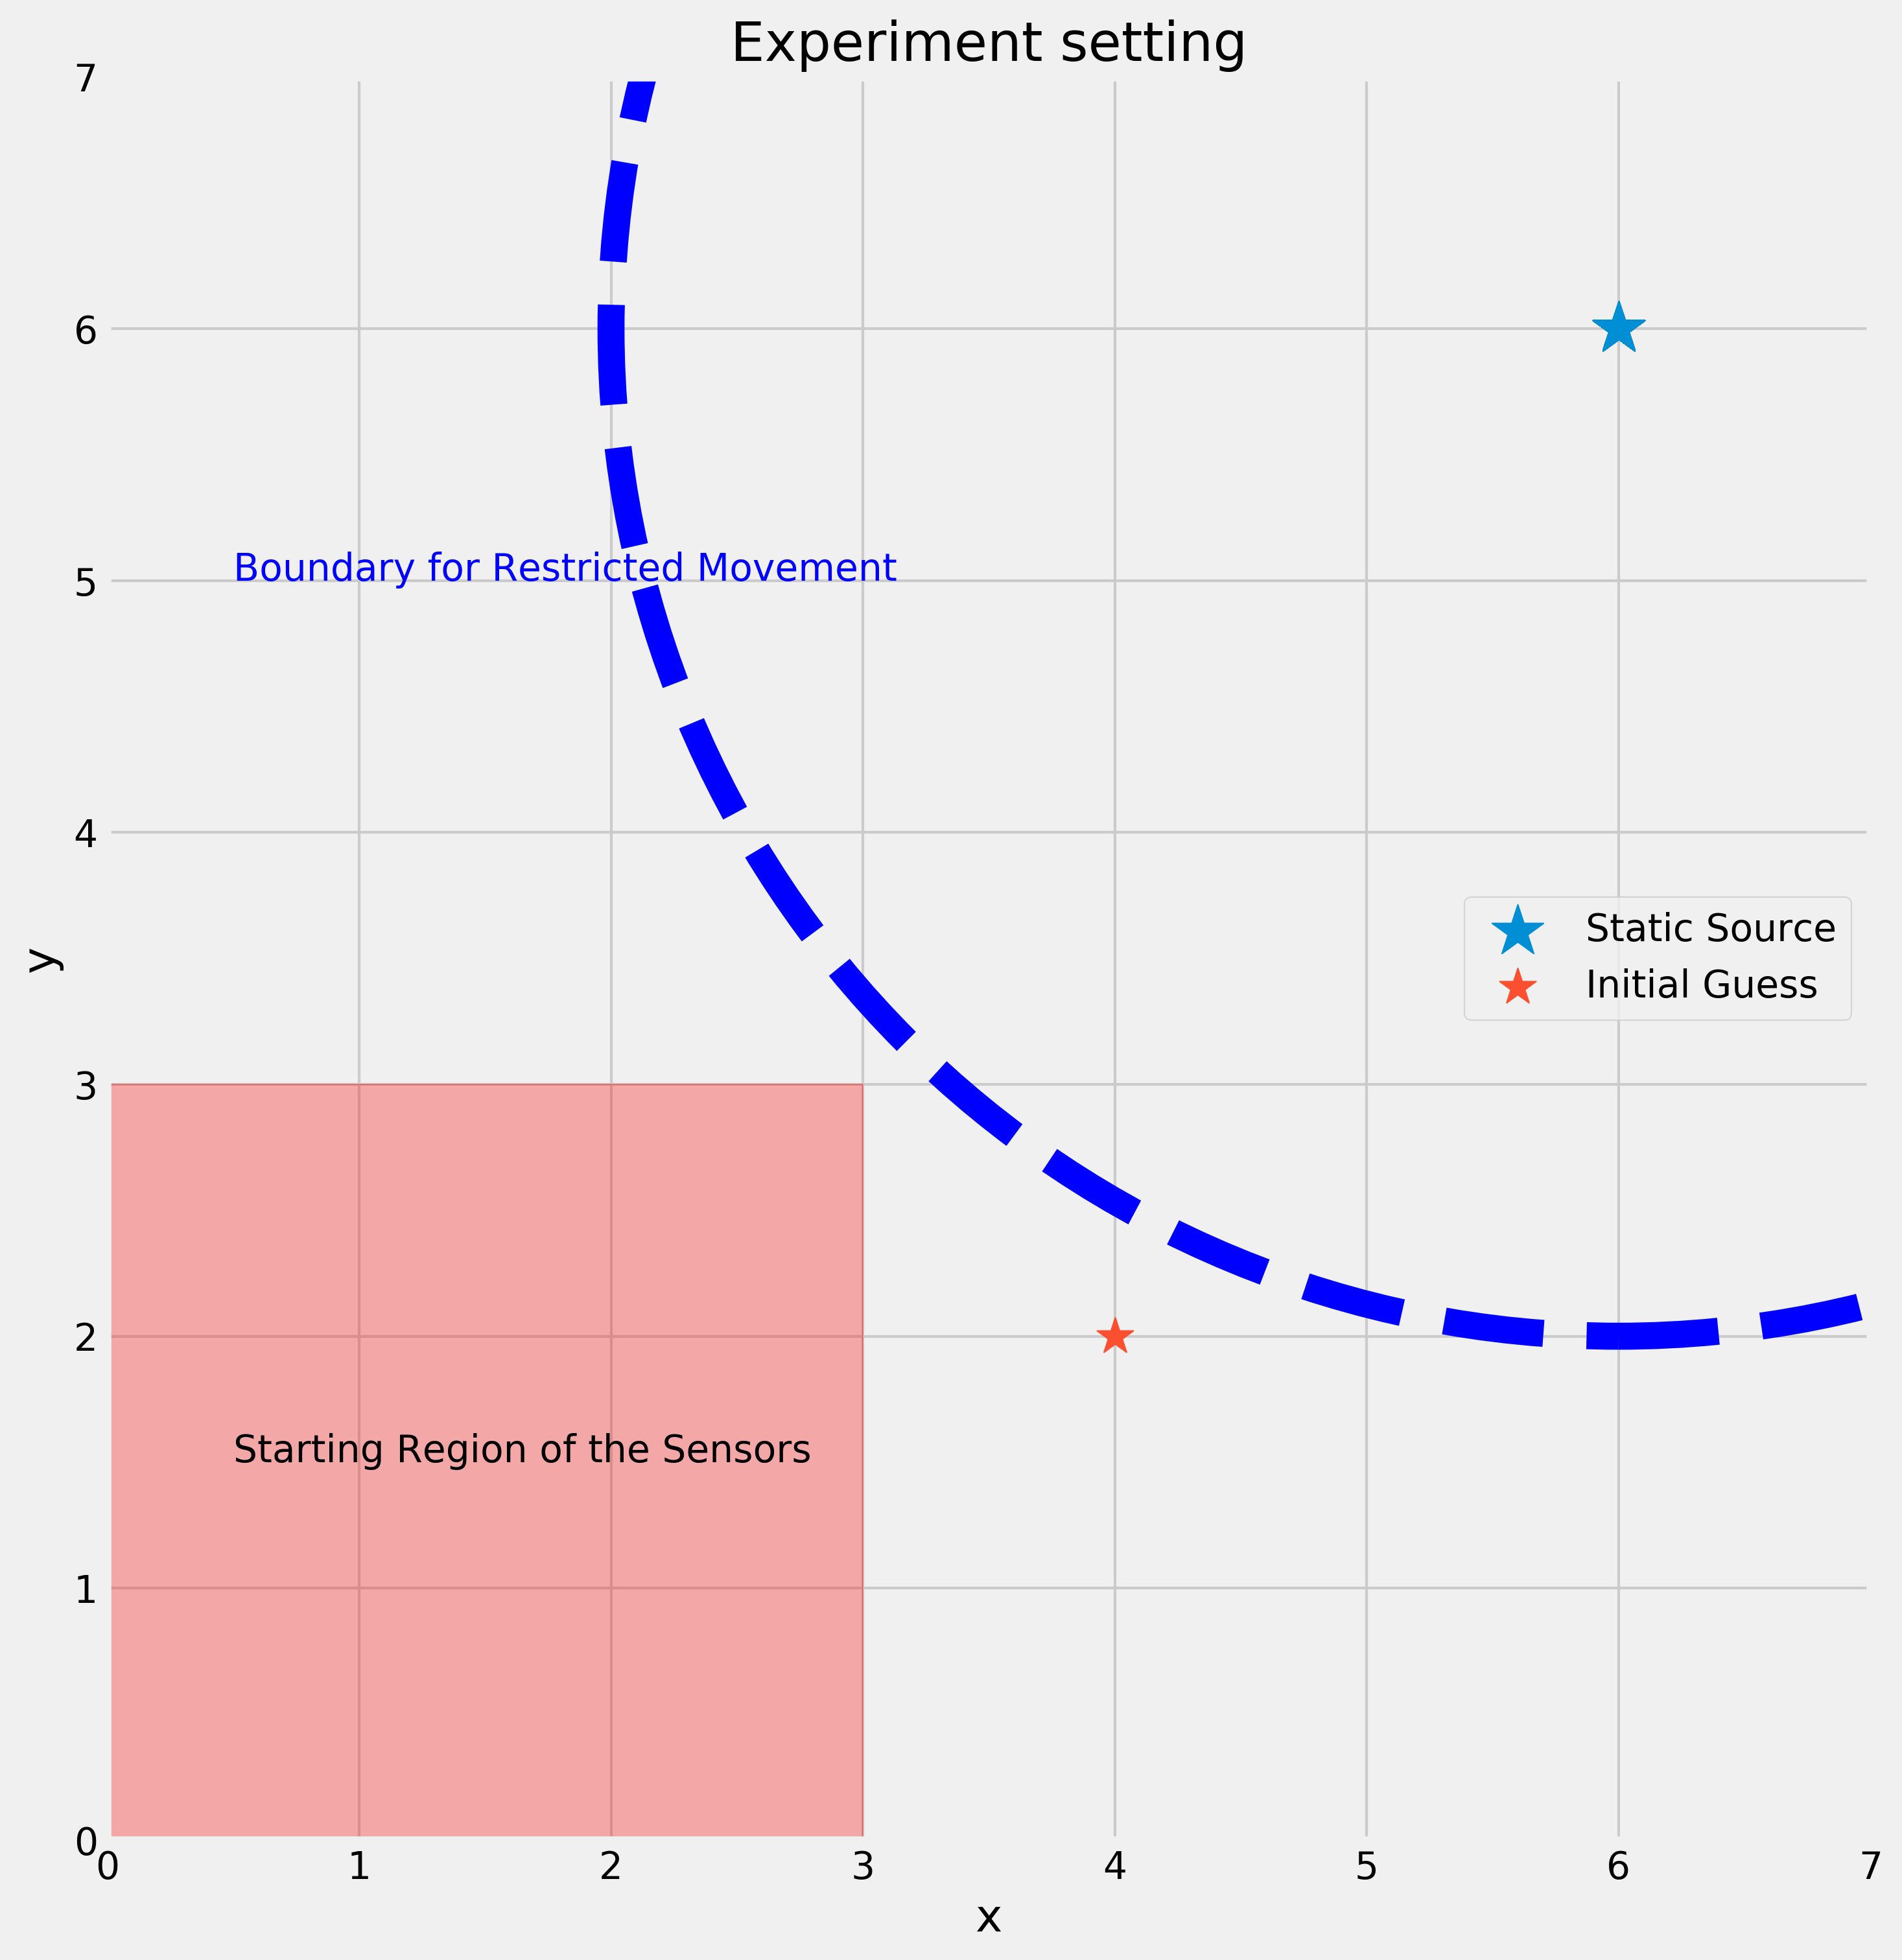

In [44]:
def plot_trajectory(ax,traj,name,marker,size=50):
    def direction_at(i):
        direction = traj[i+1,:]-traj[i,:]
        return traj[i,0],traj[i,1], direction[0],direction[1]

    ax.scatter(traj[:,0],traj[:,1],label=name,marker=marker,s = size)
	


    
def plot_dist_to_source(ax,log):
    target_locs = log['target_locs']['target_0']
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(target_locs)])
        dist = np.linalg.norm(sensor_locs[:l]-target_locs[:l],axis = 1)
        ax.plot(dist,label = key)
    ax.set_title('Sensor-Source Distance vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
#     ax.legend()
    
def plot_L(ax,log):
    q = log['target_locs']['target_0']
    ps = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(q)])
        ps.append(sensor_locs[:l])
    ps = np.hstack(ps).reshape(-1,3,2)
    Ls = [f_L(q[i,:],ps[i,:]) for i in range(l)]
    ax.plot(np.log(Ls),label = r'$\log(L(p,q))$')
    
    for key,qhat in log['est_locs_log'].items():
        if key in["ekf"]:            
            Lhat = [f_L(qhat[i,:],ps[i,:]) for i in range(l)]
            ax.plot(np.log(Lhat),label = r'$\log(L(p,qhat))$')
      
    ax.legend(loc='lower right')
#     ax.set_title('log(L(ps,q)) vs Time steps',fontsize=15)
    ax.set_ylabel('log loss')

def plot_all(log,main_title,save_file_name):
    fig = plt.figure(dpi=300,figsize=(10,15))
#     gs = fig.add_gridspec(3,3,height_ratios = [2,1,1])

    
    ax = fig.gca()    
    circle = plt.Circle((6, 6), 4, color='b', fill=False,label='Restricted Motion Boundary'\
                        ,linewidth=10,linestyle='dashed')
    ax.add_artist(circle)
    
    rectangle = plt.Rectangle((0,0), 3, 3, alpha=0.3,fc='red',ec="red")
    
    ax.add_artist(rectangle)
    ax.text(0.5,1.5,'Starting Region of the Sensors')
    ax.text(0.5,5,'Boundary for Restricted Movement',color='b')
    
    plot_experiment(ax,log)
    
#     for key,val in log['est_locs_log'].items():
#         if key in["ekf"]:
#             val = val[~(np.isnan(val))].reshape(-1,2)
#             if len(val)>0:
#                 ax = fig.add_subplot(gs[1,:])
#                 plot_err(ax,log)
#             else:
#                 pass
    ax.set_title(main_title,fontsize=20)
    
    fig.tight_layout()

    plt.savefig(save_file_name,bbox_inches='tight')


# animation function. This is called sequentially
def plot_experiment(ax,log):
#     ax.clear()

    ax.set_xlim((0,7))
    ax.set_ylim((0,7))

    ax.set_aspect('equal',adjustable='box')
           
    
    for key,val in log['target_locs'].items():
        plot_trajectory(ax,val,'Static Source','*',size = 400)

#     for key,val in log['sensor_locs'].items():
#         plot_trajectory(ax,val,key,'.',size=200)
    for key,val in log['est_locs_log'].items():
        if key in["ekf"]:
            val = val[~(np.isnan(val))].reshape(-1,2)
            if len(val)>0:

#                 plot_trajectory(ax,val,"EKF Estimation",'.',size=200)

                plot_trajectory(ax,np.array([[4,2]]),'Initial Guess','*',size = 200)
#                 print(val[:1,:])

#     ax.legend(loc='right',bbox_to_anchor=(1,0.05,0.5,1),ncol=1,fontsize=20,mode = 'expand',frameon=False)

    ax.legend(loc='right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
# num_sensors = 3
noise = ['low']
mode = ['free']
for n in noise:
    for m in mode:
        if n=='low':
            sd = 0.01
        else:
            sd = 0.1
#         print(noise,sd)
        if m == 'free':
            region = 'Free'
        else:
            region = 'Restricted'    
        save_file_name = "ExperimentSetting.png".format(m,sd)
        main_title = "Experiment setting".format(region,sd)
        filepath = 'track_log_data_{}_{}.pkl'.format(m,n)
        log = pkl.load(open(filepath,'rb'))
        plot_all(log,main_title,save_file_name)
        
        
#         save_file_name = "{}_noise{}_moving.png".format(m,sd)
#         main_title = "{} movement, moving source \n noise={}".format(region,sd)
#         filepath = 'track_log_data_{}_moving_{}.pkl'.format(m,n)
#         log = pkl.load(open(filepath,'rb'))
#         plot_all(log,main_title,save_file_name)

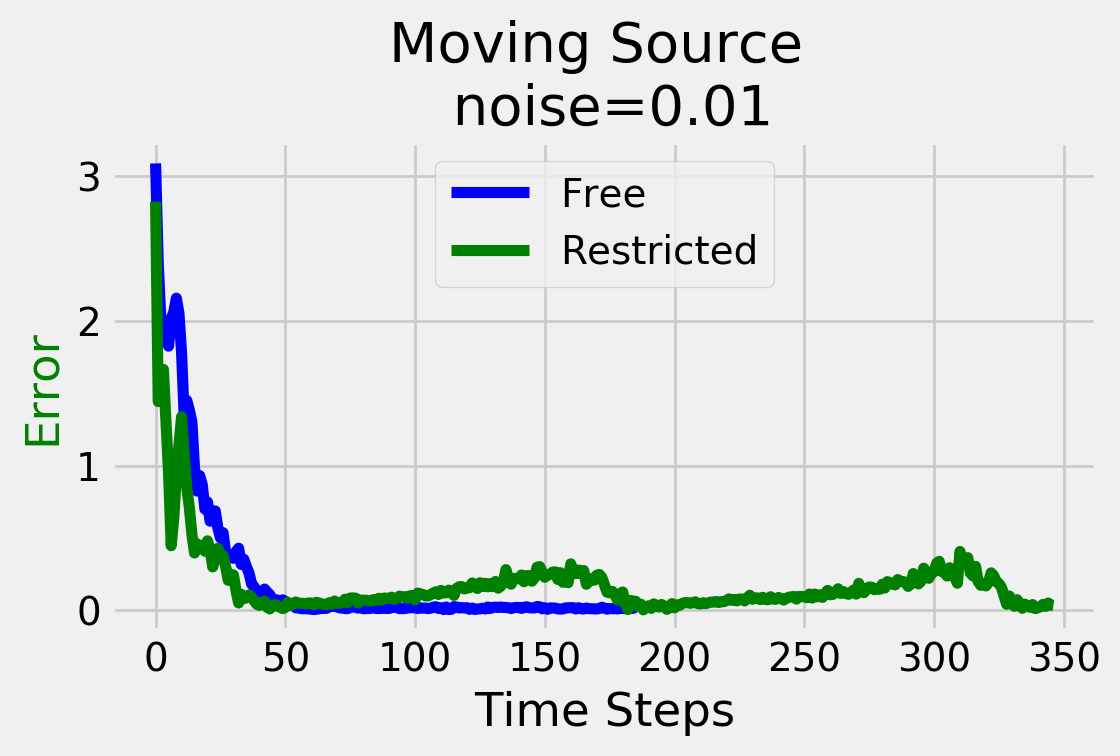

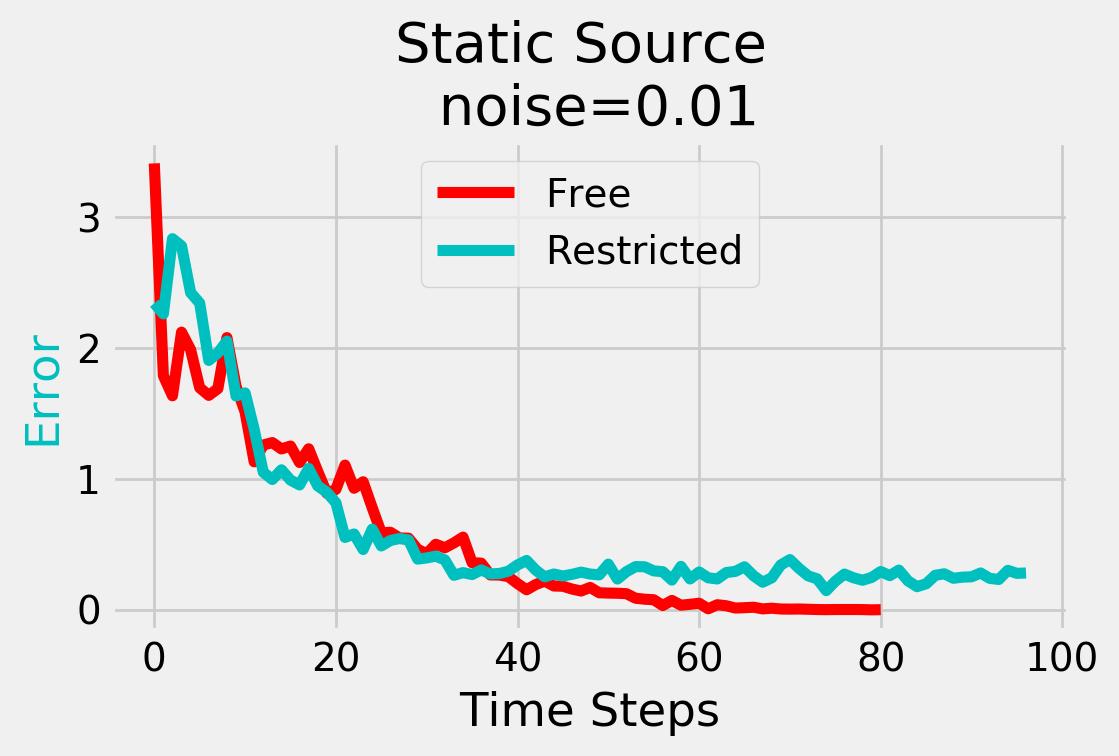

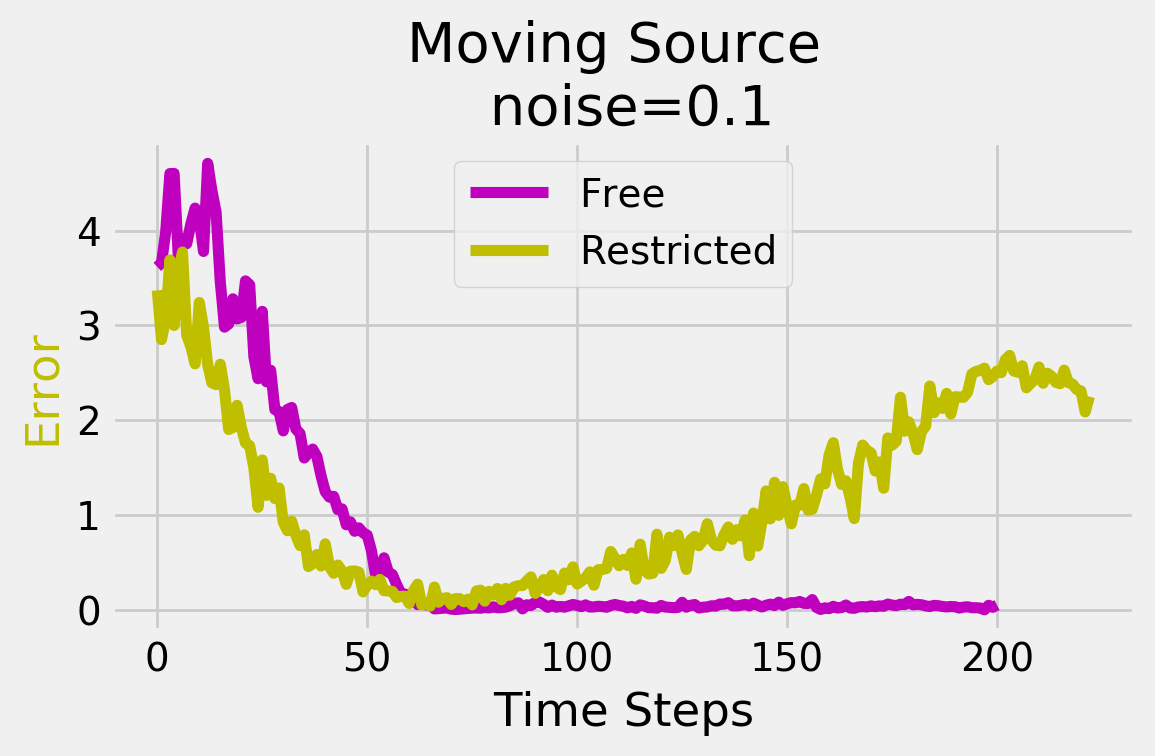

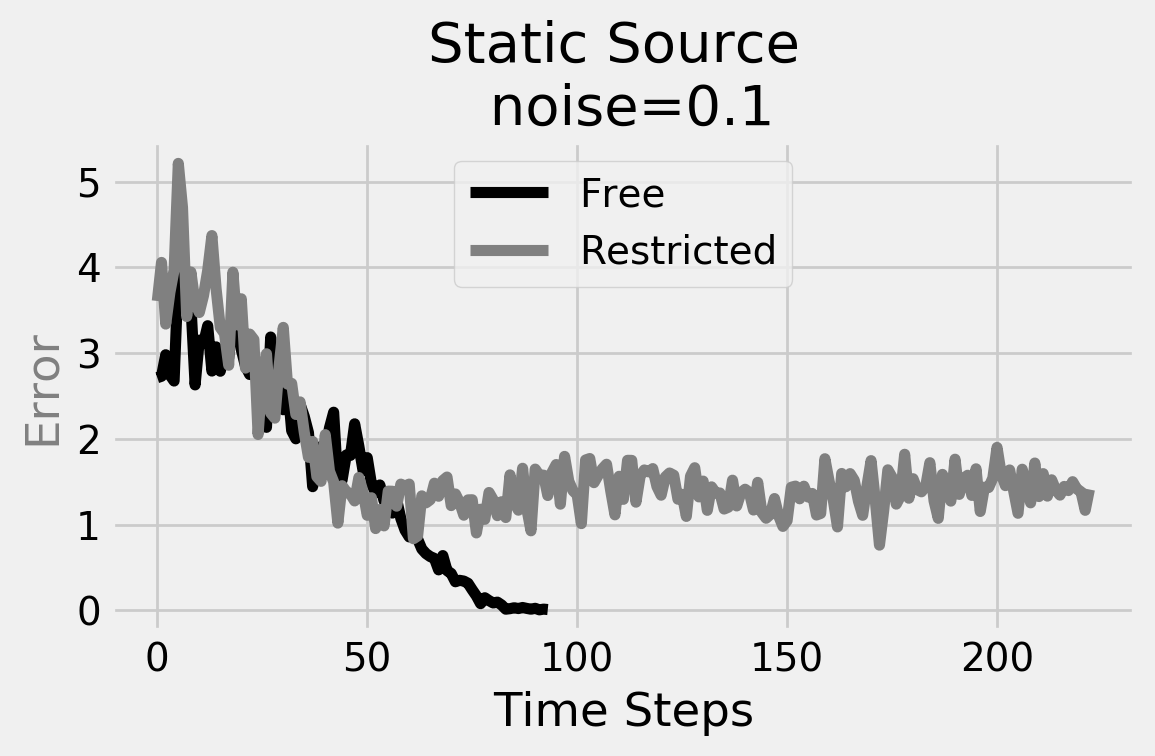

In [35]:
colors = ['b','g','r','c','m','y','k','grey']

noise = ['low','high']
mode = ['free','rad4']
moving = ['_moving','']
i = 0
for n in noise:
    for mv in moving:
        if n=='low':
            sd = 0.01
        else:
            sd = 0.1
        
        fig=plt.figure(dpi=200)
        ax = fig.gca()
        
        if mv=='_moving':
            main_title = "Moving Source \n noise={}".format(sd)
            save_file_name = "Compare_MovingSource_noise{}.png".format(sd)
        else:
            main_title = "Static Source \n noise={}".format(sd)
            save_file_name = "StaticSource_noise{}.png".format(sd)
        ax.set_title(main_title)
            
        for m in mode:
            
            filepath = 'track_log_data_{}{}_{}.pkl'.format(m,mv,n)
            log = pkl.load(open(filepath,'rb'))
            if m == 'free':
                region = 'Free'
            else:
                region = 'Restricted'  

            plot_err(ax,log,color=colors[i],name=region)
            
            i+=1
        fig.tight_layout()
        fig.savefig(save_file_name)


Text(0.5, 1.0, 'Following Gradient Descent')

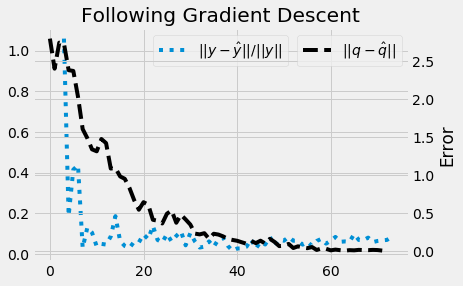

In [104]:

filepath = 'track_log_data_FIM.pkl'
log = pkl.load(open(filepath,'rb'))

meas_func=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes meas_func(x,ps)


q = log['target_locs']['target_0']
qhat = log['est_locs_log']['ekf']
ps = []
ys = []
for key,sensor_locs in log['sensor_locs'].items():
    l = np.min([len(sensor_locs),len(qhat)])
    ps.append(sensor_locs[:l])
    y = log['scalar_readings'][key]
    ys.append(y)
ps = np.hstack(ps).reshape(-1,3,2)
ys = np.hstack(ys).reshape(-1,3)

yhats = np.vstack([np.array(meas_func(qhat[i],ps[i])) for i in range(len(ys))])
yreal = np.vstack([np.array(meas_func(q[i],ps[i])) for i in range(len(ys))])

plt.plot(np.linalg.norm(ys-yhats,axis=1)/np.linalg.norm(ys,axis=1),linestyle = 'dotted',label = r'$||y-\hat{y}||/||y||$')
plt.legend(loc = 'upper center')
ax = plt.gca().twinx()
plot_err(ax,log)
plt.legend()
plt.title('Following Gradient Descent')

Text(0.5, 1.0, 'Directly head towards Est. Locations')

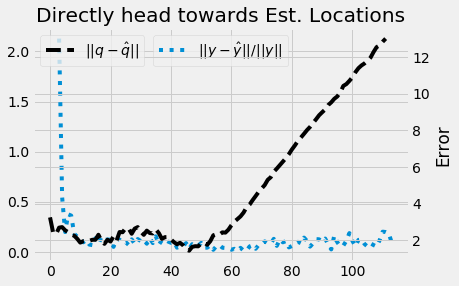

In [106]:
filepath = 'track_log_data_StraightLine.pkl'
log = pkl.load(open(filepath,'rb'))

meas_func=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes meas_func(x,ps)

q = log['target_locs']['target_0']
qhat = log['est_locs_log']['ekf']
ps = []
ys = []
for key,sensor_locs in log['sensor_locs'].items():
    l = np.min([len(sensor_locs),len(qhat)])
    ps.append(sensor_locs[:l])
    y = log['scalar_readings'][key]
    ys.append(y)
ps = np.hstack(ps).reshape(-1,3,2)
ys = np.hstack(ys).reshape(-1,3)

yhats = np.vstack([np.array(meas_func(qhat[i],ps[i])) for i in range(len(ys))])
yreal = np.vstack([np.array(meas_func(q[i],ps[i])) for i in range(len(ys))])

plt.plot(np.linalg.norm(ys-yhats,axis=1)/np.linalg.norm(ys,axis=1),linestyle = 'dotted',label = r'$||y-\hat{y}||/||y||$')
plt.legend(loc = 'upper center')
ax = plt.gca().twinx()
plot_err(ax,log)
plt.legend()
plt.title("Directly head towards Est. Locations")